In [11]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataset import DefectDataset, my_collate
from torch.utils.data import DataLoader
import scipy.io as sio
from model.defeat_detect import DefeatDetectModel

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DefeatDetectModel(512).to(device)
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()

DefeatDetectModel(
  (cnn): CnnBackend(
    (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (pool1): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (cbam1): CBAM(
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=16, out_features=1, bias=False)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=16, bias=False)
      )
      (sigmoid): Sigmoid()
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (res16): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-0

In [17]:
file_name = 'data/final_data_sim_{:04d}.mat'
file_num = 32
train_ratio = 0.1
scan_num = 32
gridN = 512
test_data = DefectDataset(file_name, file_num - int(file_num * train_ratio))
test_loader = DataLoader(test_data, shuffle=False, collate_fn=my_collate)

Loading data...


100%|██████████| 29/29 [00:46<00:00,  1.59s/it]

Data loaded.


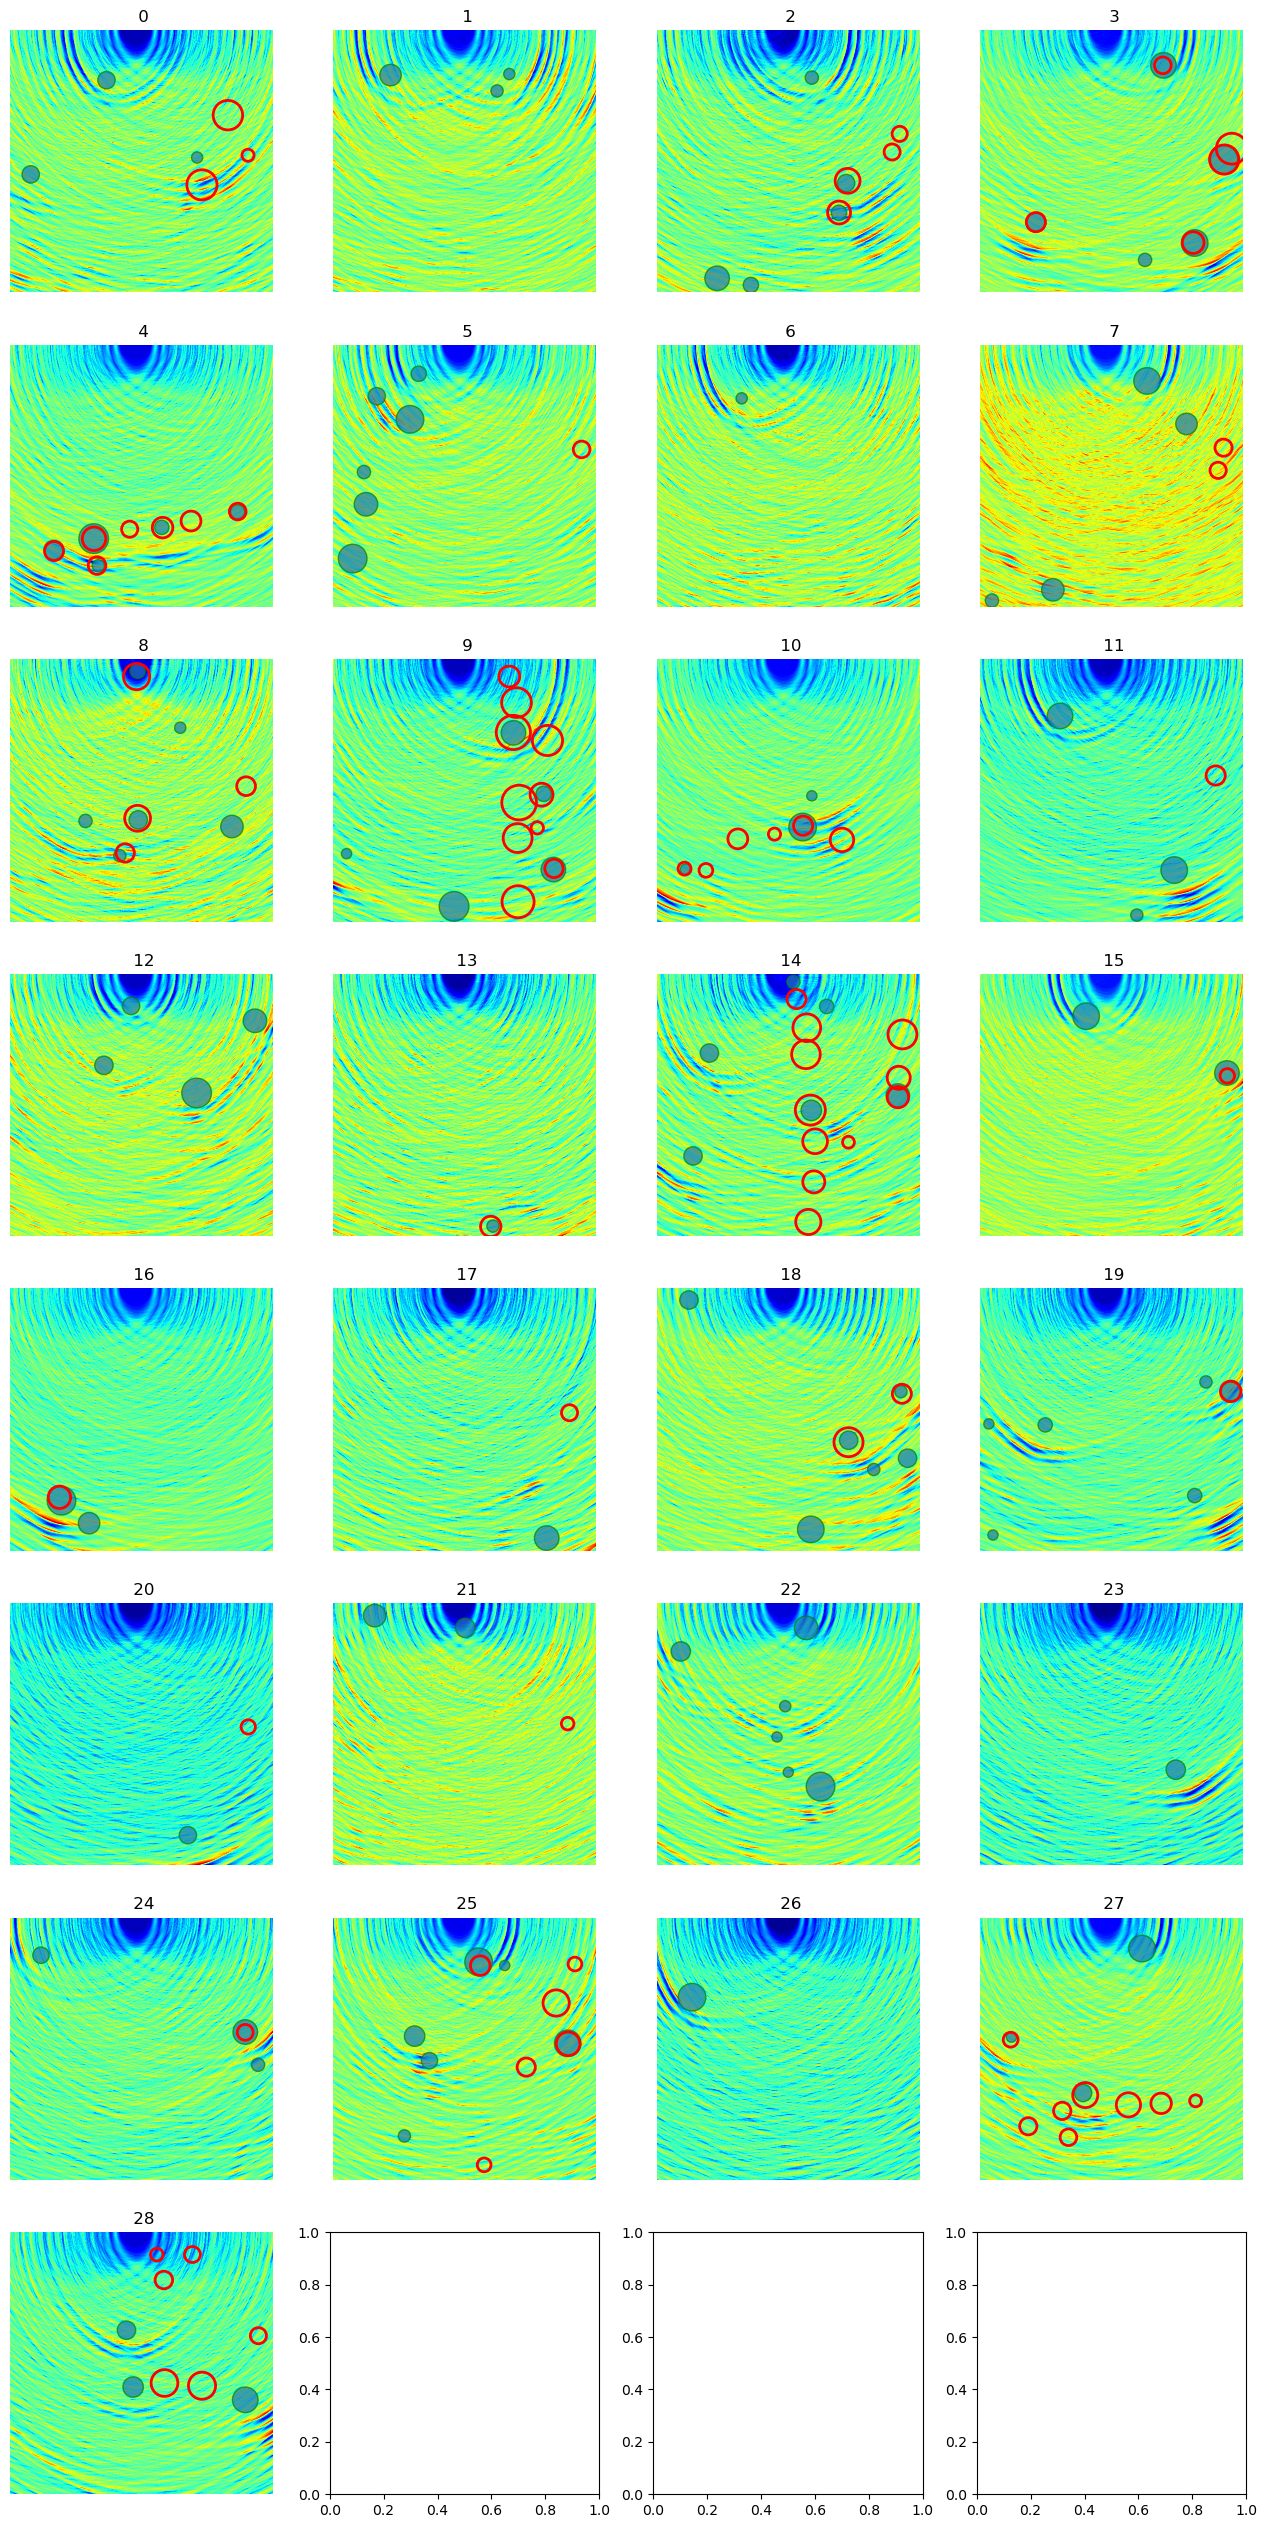

In [22]:
prob_threshold = 0.1

fig, ax = plt.subplots(
    max((len(test_loader) // scan_num + 3) // 4, 2), 4,
    figsize=(16, 4 * ((len(test_loader) // scan_num + 3) // 4))
)

for i, (phase, label) in enumerate(test_loader):
    if i % scan_num != 0:
        continue

    phase = phase.to(device)
    pred = model(phase)[0].detach().cpu().numpy()
    phase = phase[0].detach().cpu().numpy()

    ind = i // scan_num
    ax[ind // 4, ind % 4].imshow(phase, cmap='jet')
    ax[ind // 4, ind % 4].set_title(f' {ind}')
    ax[ind // 4, ind % 4].axis('off')

    # Draw ground truth
    boxN = 8
    boxLen = gridN / boxN
    for truth in label[0]:
        x, y, r = truth[2] * boxLen, truth[3] * boxLen, truth[4] * boxLen
        basex, basey = truth[0] * boxLen, truth[1] * boxLen
        x, y = x + basex, y + basey
        rect = patches.Circle((y, x), r, edgecolor='g', alpha=0.7)
        ax[ind // 4, ind % 4].add_patch(rect)
    
    # Draw prediction
    for i in range(boxN):
        for j in range(boxN):
            if pred[i][j][3] > prob_threshold:
                x, y, r = pred[i][j][:3] * boxLen
                basex, basey = i * boxLen, j * boxLen
                x, y = x + basex, y + basey
                rect = patches.Circle((y, x), r, edgecolor='r', lw=2, facecolor='none')
                ax[ind // 4, ind % 4].add_patch(rect)
            
            if pred[i][j][7] > prob_threshold:
                x, y, r = pred[i][j][4:7] * boxLen
                basex, basey = i * boxLen, j * boxLen
                x, y = x + basex, y + basey
                rect = patches.Circle((y, x), r, edgecolor='r', lw=2, facecolor='none')
                ax[ind // 4, ind % 4].add_patch(rect)

plt.show()